In [ ]:
!nvidia-smi

Wed Aug 23 05:42:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install torch torchvision

In [ ]:
import os
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

In [ ]:
###### Data Setting

batch_size = 256                 # the number of data in each iteration

# optionally load a model
tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


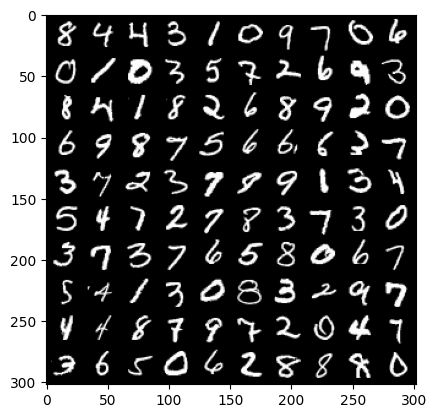

In [ ]:
sample_batch = next(iter(dataloader))[0][:100]

plt.imshow(make_grid(sample_batch, nrow=10).permute(1, 2, 0), cmap='gray')
plt.show()
plt.close()

In [ ]:
def beta_schedule(beta1, beta2, T, schedule='sigmoid'):
    if schedule == 'linear':
        betas = torch.linspace(beta1, beta2, T)
    elif schedule == "quad":
        betas = torch.linspace(beta1 ** 0.5, beta2 ** 0.5, T) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, T)
        betas = torch.sigmoid(betas) * (beta2 - beta1) + beta1
    return betas

def ddpm_schedules(beta1, beta2, T, schedule='sigmoid'):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = beta_schedule(beta1, beta2, T, schedule)
    # beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "beta_t": beta_t,    # \beta_t
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }



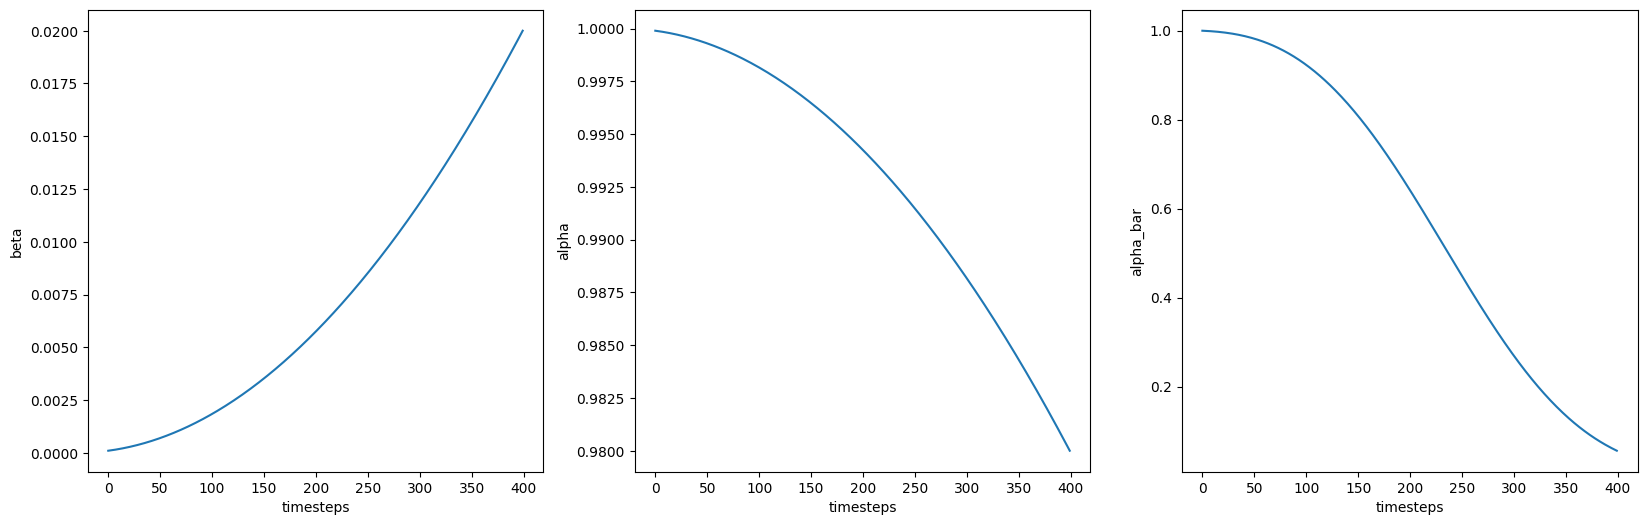

In [ ]:
# ddpm scheduling check

import matplotlib.pyplot as plt

n_T = 400

ddpm_scheduling_dict = ddpm_schedules(1e-4, 0.02, n_T, schedule='quad')

beta = ddpm_scheduling_dict['beta_t']
alpha = ddpm_scheduling_dict['alpha_t']
alpha_bar = ddpm_scheduling_dict['alphabar_t']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

axes[0].plot(np.arange(len(beta)), beta)
axes[0].set_xlabel('timesteps')
axes[0].set_ylabel('beta')

axes[1].plot(np.arange(len(alpha)), alpha)
axes[1].set_xlabel('timesteps')
axes[1].set_ylabel('alpha')

axes[2].plot(np.arange(len(alpha_bar)), alpha_bar)
axes[2].set_xlabel('timesteps')
axes[2].set_ylabel('alpha_bar')

plt.show()
plt.close()

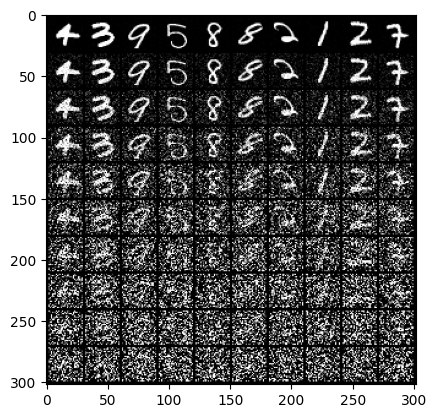

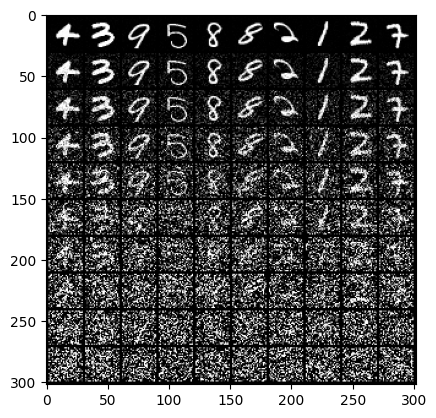

In [ ]:
sample_batch = next(iter(dataloader))[0][:10]

forward_list = []
forward_list2 = []

x = sample_batch
for t in range(n_T):
    x = torch.sqrt(1 - ddpm_scheduling_dict['beta_t'][t, None, None, None]) * x + torch.sqrt(ddpm_scheduling_dict['beta_t'][t, None, None, None]) * torch.randn_like(x)
    if t % (n_T//10) == 0:
        forward_list.append(x.detach().cpu())

for t in range(400):
    if t % (n_T//10) == 0:
        x = ddpm_scheduling_dict['sqrtab'][t, None, None, None] * sample_batch + ddpm_scheduling_dict['sqrtmab'][t, None, None, None] * torch.randn_like(sample_batch)
        forward_list2.append(x.detach().cpu())

plt.imshow(make_grid(torch.cat(forward_list), nrow=10).permute(1, 2, 0), cmap='gray')
plt.show()
plt.close()

plt.imshow(make_grid(torch.cat(forward_list2), nrow=10).permute(1, 2, 0), cmap='gray')
plt.show()
plt.close()

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t):
        # x is (noisy) image, c is context label, t is timestep,
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [ ]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(0, self.n_T, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T))

    def sample(self, n_sample, size, device):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        x_i_store = [] # keep track of generated steps in case want to plot something
        for i in range(self.n_T-1, -1, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is)
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [ ]:
device='cuda:0'
n_epoch = 40                     # total training epoch
n_T = 500                        # total timesteps of diffusion process
n_classes = 10                   # the number of class in dataset
n_feat = 256                     # feature dimension of UNet : 128 ok, 256 better (but slower)
lrate = 1e-4                     # learning rate
save_dir = './mnist_data_results/'
os.makedirs(save_dir, exist_ok=True)

ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device)
ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

In [ ]:
plt.ioff()

# Training
for ep in range(n_epoch):
    print(f'epoch {ep}')
    ddpm.train()

    # linear lrate decay
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, c in pbar:
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        loss = ddpm(x, c)
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

    # for eval, save an image of currently generated samples (top rows)
    # followed by real images (bottom rows)
    ddpm.eval()
    with torch.no_grad():
        n_sample = 4*n_classes
        x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device)

        # append some real images at bottom, order by class also
        x_real = torch.Tensor(x_gen.shape).to(device)
        for k in range(n_classes):
            for j in range(int(n_sample/n_classes)):
                try:
                    idx = torch.squeeze((c == k).nonzero())[j]
                except:
                    idx = 0
                x_real[k+(j*n_classes)] = x[idx]

        x_all = torch.cat([x_gen, x_real])
        grid = make_grid(x_all, nrow=10)
        save_image(grid, save_dir + f"image_ep{ep}.png")
        print('saved image at ' + save_dir + f"image_ep{ep}.png")

        if ep%5==0 or ep == int(n_epoch-1):
            # create gif of images evolving over time, based on x_gen_store
            fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
            def animate_diff(i, x_gen_store):
                print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                plots = []
                for row in range(int(n_sample/n_classes)):
                    for col in range(n_classes):
                        axs[row, col].clear()
                        axs[row, col].set_xticks([])
                        axs[row, col].set_yticks([])
                        # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                        plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(x_gen_store[i]).min(), vmax=(x_gen_store[i]).max()))
                return plots
            ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])
            ani.save(save_dir + f"gif_ep{ep}.gif", dpi=100, writer=PillowWriter(fps=5))
            print('saved image at ' + save_dir + f"gif_ep{ep}.gif")
            plt.close('all')

    # optionally save model
    if ep == int(n_epoch-1):
        torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


loss: 0.0637: 100%|██████████| 235/235 [05:21<00:00,  1.37s/it]


saved image at ./mnist_data_results/image_ep0.png
saved image at ./mnist_data_results/gif_ep0.gif
epoch 1


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loss: 0.0487: 100%|██████████| 235/235 [05:24<00:00,  1.38s/it]


saved image at ./mnist_data_results/image_ep1.png
epoch 2


loss: 0.0454: 100%|██████████| 235/235 [05:23<00:00,  1.38s/it]


saved image at ./mnist_data_results/image_ep2.png
epoch 3


loss: 0.0416: 100%|██████████| 235/235 [05:22<00:00,  1.37s/it]


saved image at ./mnist_data_results/image_ep3.png
epoch 4


loss: 0.0399: 100%|██████████| 235/235 [05:23<00:00,  1.38s/it]


saved image at ./mnist_data_results/image_ep4.png
epoch 5


loss: 0.0387: 100%|██████████| 235/235 [05:23<00:00,  1.38s/it]


saved image at ./mnist_data_results/image_ep5.png
saved image at ./mnist_data_results/gif_ep5.gif
epoch 6


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loss: 0.0382: 100%|██████████| 235/235 [05:24<00:00,  1.38s/it]


saved image at ./mnist_data_results/image_ep6.png
epoch 7


loss: 0.0373: 100%|██████████| 235/235 [05:22<00:00,  1.37s/it]


saved image at ./mnist_data_results/image_ep7.png
epoch 8


loss: 0.0373: 100%|██████████| 235/235 [05:23<00:00,  1.38s/it]


saved image at ./mnist_data_results/image_ep8.png
epoch 9


loss: 0.0353: 100%|██████████| 235/235 [05:23<00:00,  1.38s/it]


saved image at ./mnist_data_results/image_ep9.png
epoch 10


loss: 0.0351: 100%|██████████| 235/235 [05:23<00:00,  1.38s/it]


saved image at ./mnist_data_results/image_ep10.png
saved image at ./mnist_data_results/gif_ep10.gif
epoch 11


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loss: 0.0369:   9%|▊         | 20/235 [00:30<05:25,  1.51s/it]


KeyboardInterrupt: ignored

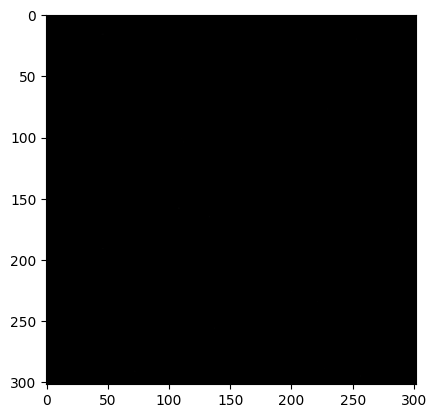

In [ ]:
num_samples = 100

x = torch.randn((num_samples, 1, 28, 28), device=device) # xT ~ N(0, I)
c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
c_i = c_i.repeat(int(num_samples/c_i.shape[0]))
x_store = []
with torch.no_grad():
    for i in range(n_T-1, -1, -1):
        t_is = torch.tensor([i / n_T]).to(device)
        t_is = t_is.repeat(num_samples, 1, 1, 1)

        eps = ddpm.nn_model(x, c_i, t_is)
        x = ddpm.oneover_sqrta[i, None, None, None] * (x - eps * ddpm.mab_over_sqrtmab[i]) + ddpm.sqrt_beta_t[i, None, None, None] * torch.randn_like(x)
        if i % 20 == 0 or i == n_T or i < 8:
            x_store.append(x.detach().cpu().numpy())


plt.imshow(make_grid(x.cpu(), nrow=10).permute(1, 2, 0), cmap='gray')
plt.show()
plt.close()